## Declaring libraries and downloading dataset


In [68]:
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [69]:
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())
test_dataset = CIFAR100(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [70]:
print(len(dataset))
print(len(test_dataset))

classes = dataset.classes 
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

#shape of the image tensor
img, label = dataset[31]
img_shape = img.shape
img_shape

50000
10000
Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tul

torch.Size([3, 32, 32])

In [71]:
print("1 - Max & Min Pixel Values:", "Max:", torch.max(img), "Min:", torch.min(img))
print("2 - Pixel Values for all Channels:\n", img[:, 20:25, 20:25])

1 - Max & Min Pixel Values: Max: tensor(1.) Min: tensor(0.1020)
2 - Pixel Values for all Channels:
 tensor([[[0.5569, 0.6039, 0.6510, 0.6039, 0.8235],
         [0.3961, 0.5922, 0.7529, 0.6824, 0.8314],
         [0.2941, 0.5294, 0.6275, 0.6078, 0.6784],
         [0.3255, 0.4471, 0.4353, 0.4235, 0.4275],
         [0.4667, 0.4667, 0.5020, 0.5725, 0.4706]],

        [[0.4353, 0.4745, 0.5020, 0.4549, 0.6510],
         [0.3020, 0.4706, 0.5882, 0.5098, 0.6706],
         [0.2471, 0.4196, 0.4745, 0.4431, 0.5333],
         [0.2667, 0.3529, 0.3098, 0.2941, 0.3098],
         [0.3922, 0.4039, 0.4196, 0.4902, 0.3922]],

        [[0.4392, 0.4824, 0.5137, 0.4627, 0.6667],
         [0.3020, 0.4745, 0.6000, 0.5216, 0.6745],
         [0.2431, 0.4353, 0.4980, 0.4627, 0.5373],
         [0.2627, 0.3569, 0.3176, 0.2980, 0.3059],
         [0.3490, 0.3490, 0.3647, 0.4314, 0.3333]]])


## Preparing Dataset

In [72]:
torch.manual_seed(2718) ##settling a manual seed to get similar results everytime

val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [73]:
batch_size = 128

In [74]:
# Defininf Loaders for training process
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory =True)

In [75]:
torch.cuda.is_available()

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

idk


In [76]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

## Using ResNet 9 structure to train the model

In [77]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes),
                                        nn.Softmax())
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [78]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [79]:
model_resnet9 = to_device(ResNet9(3, 100), device)
model_resnet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [80]:
history_resnet9 = [evaluate(model_resnet9, val_loader)]
history_resnet9

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[{'val_loss': 4.605168342590332, 'val_acc': 0.010284810326993465}]

**Setting parameters for training**

In [81]:
epochs_resnet9 = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [82]:
%%time
history_resnet9 += fit_one_cycle(epochs_resnet9, max_lr, model_resnet9, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00050, train_loss: 4.5723, val_loss: 4.5773, val_acc: 0.0445
Epoch [1], last_lr: 0.00081, train_loss: 4.5623, val_loss: 4.5741, val_acc: 0.0474
Epoch [2], last_lr: 0.00132, train_loss: 4.5687, val_loss: 4.5772, val_acc: 0.0439
Epoch [3], last_lr: 0.00199, train_loss: 4.5747, val_loss: 4.5803, val_acc: 0.0415
Epoch [4], last_lr: 0.00280, train_loss: 4.5802, val_loss: 4.5984, val_acc: 0.0229
Epoch [5], last_lr: 0.00371, train_loss: 4.5870, val_loss: 4.5972, val_acc: 0.0247
Epoch [6], last_lr: 0.00470, train_loss: 4.5914, val_loss: 4.6025, val_acc: 0.0193
Epoch [7], last_lr: 0.00570, train_loss: 4.5952, val_loss: 4.6136, val_acc: 0.0086
Epoch [8], last_lr: 0.00668, train_loss: 4.6119, val_loss: 4.6136, val_acc: 0.0086
Epoch [9], last_lr: 0.00760, train_loss: 4.6096, val_loss: 4.6136, val_acc: 0.0086
Epoch [10], last_lr: 0.00841, train_loss: 4.6115, val_loss: 4.6012, val_acc: 0.0190
Epoch [11], last_lr: 0.00908, train_loss: 4.5981, val_loss: 4.6045, val_acc: 0.0158
Ep

### Evaluating

In [83]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

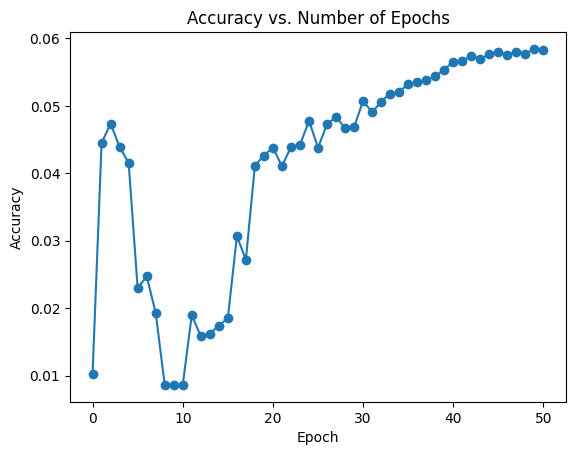

In [84]:
plot_accuracies(history_resnet9)

In [85]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

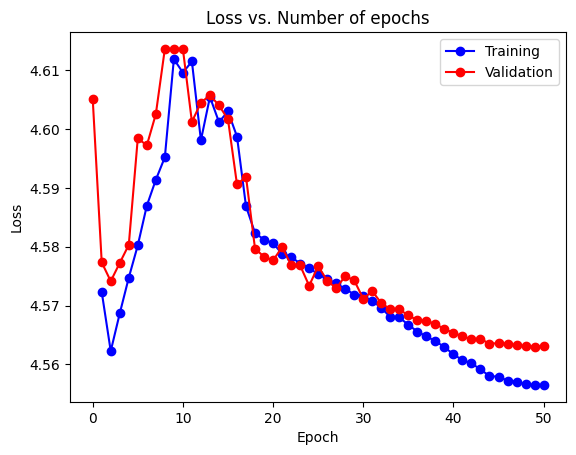

In [86]:
plot_losses(history_resnet9)

In [87]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number');

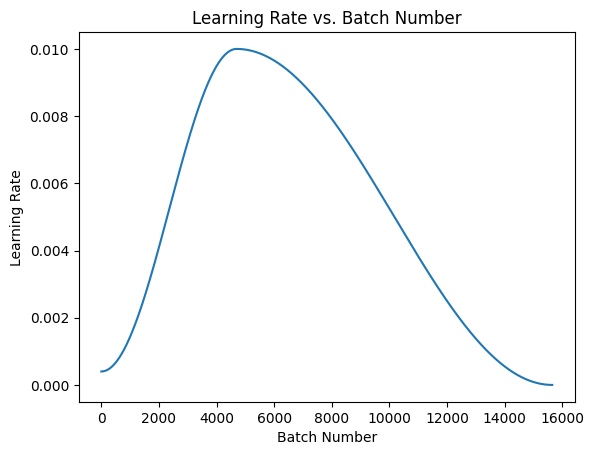

In [88]:
plot_lrs(history_resnet9)

In [89]:
test_resnet9 = evaluate(model_resnet9, test_loader) #final evaluation of resnet9 model with test dataset
test_resnet9

{'val_loss': 4.564822673797607, 'val_acc': 0.0569620244204998}

In [90]:
test_loss_resnet9 = test_resnet9['val_loss']
test_acc_resnet9 = test_resnet9['val_acc']
print('test_loss_resnet9:', test_resnet9['val_loss'])
print('test_acc_resnet9:', test_resnet9['val_acc'])

test_loss_resnet9: 4.564822673797607
test_acc_resnet9: 0.0569620244204998


In [91]:
torch.save(model_resnet9.state_dict(), 'ResNet9_v0.pth')

In [92]:
def predict_image(img, model_resnet9):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model_resnet9(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: oak_tree , Predicted: leopard


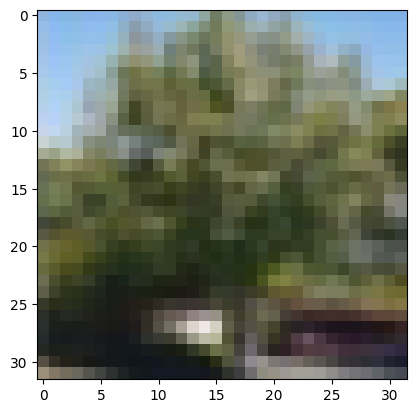

In [93]:
img, label = test_dataset[8543]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_resnet9))